# OLS, Lasso & Ridge

### Libraries

In [55]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Display the first few rows of each DataFrame as scrollable tables in Jupyter Notebook
from IPython.display import display
import holidays

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [6]:
# Load the electricity consumption dataset
consumption_filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Energy/Production and Consumption - Settlement.csv'
consumption_df = pd.read_csv(consumption_filepath)

# Load the weather forecast dataset
weather_filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Weather forecasts/combined_forecasts_2005-2023.csv'
weather_df = pd.read_csv(weather_filepath)


# Display the electricity consumption DataFrame
print("Electricity Consumption Data:")
display(consumption_df.head())

# Display the weather forecast DataFrame
print("Weather Forecast Data:")
display(weather_df.head())

Electricity Consumption Data:


,HourUTC,HourDK,PriceArea,CentralPowerMWh,LocalPowerMWh,CommercialPowerMWh,LocalPowerSelfConMWh,OffshoreWindLt100MW_MWh,OffshoreWindGe100MW_MWh,OnshoreWindLt50kW_MWh,...,ExchangeNO_MWh,ExchangeSE_MWh,ExchangeGE_MWh,ExchangeNL_MWh,ExchangeGreatBelt_MWh,GrossConsumptionMWh,GridLossTransmissionMWh,GridLossInterconnectorsMWh,GridLossDistributionMWh,PowerToHeatMWh
0,2005-03-25T22:00:00,2005-03-25T23:00:00,DK1,917.400024,760.206787,NaN,0.0,4.857113,0.000000,0.022235,...,496.000000,-97.099998,-297.700012,0.0,0.0,1842.515015,0.0,NaN,NaN,0.0
1,2005-03-25T22:00:00,2005-03-25T23:00:00,DK2,920.900024,271.390656,NaN,0.0,3.329244,2.978000,0.006352,...,NaN,386.600006,-251.000000,NaN,0.0,1386.037964,0.0,NaN,NaN,0.0
2,2005-03-25T21:00:00,2005-03-25T22:00:00,DK1,1079.099976,772.546753,NaN,0.0,4.533219,0.000000,0.015721,...,808.599976,169.699997,-870.299988,0.0,0.0,2010.311157,0.0,NaN,NaN,0.0
3,2005-03-25T21:00:00,2005-03-25T22:00:00,DK2,908.099976,296.979065,NaN,0.0,5.279539,44.057999,0.008078,...,NaN,631.500000,-447.000000,NaN,0.0,1501.229004,0.0,NaN,NaN,0.0
4,2005-03-25T20:00:00,2005-03-25T21:00:00,DK1,1125.400024,833.091309,NaN,0.0,3.346528,0.000000,0.012367,...,991.400024,431.600006,-1245.199951,0.0,0.0,2180.373779,0.0,NaN,NaN,0.0


Weather Forecast Data:


,valid_time,time,step,t2m
0,2005-01-01 06:00:00,2005-01-01,0 days 06:00:00,3.090616
1,2005-01-01 12:00:00,2005-01-01,0 days 12:00:00,4.884995
2,2005-01-01 18:00:00,2005-01-01,0 days 18:00:00,5.163322
3,2005-01-02 00:00:00,2005-01-01,1 days 00:00:00,5.461974
4,2005-01-02 06:00:00,2005-01-01,1 days 06:00:00,3.571397


### Electricity Consumption Data
* `HourUTC` and `HourDK`: Timestamps in UTC and Danish time
* `PriceArea`: Price area (either DK1 or DK2)
* `CentralPowerMWh`, `LocalPowerMWh`, etc.: Various measures of electricity consumption and production
* `GrossConsumptionMWh`: The measure we are interested in for electricity consumption
### Weather Data
* `valid_time`: The valid time for the weather forecast
* `time`: The date of the forecast
* `step`: The step length for the forecast (e.g., "0 days 06:00:00" means 6 hours ahead)
* `t2m`: Temperature in degrees Celsius

### Combining the datasets

First we have to manipulate the data a little by:
1. Turning the datasets into timeseries
2. Cut the unwanted variable
3. Combine the data sets.

In [7]:
# Convert the relevant columns to datetime format
consumption_df['HourDK'] = pd.to_datetime(consumption_df['HourDK'])
weather_df['valid_time'] = pd.to_datetime(weather_df['valid_time'])

# Show the data types to confirm the conversion
consumption_df.dtypes['HourDK'], weather_df.dtypes['valid_time']

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [8]:
# Summing up GrossConsumptionMWh for both DK1 and DK2 for each time slot
consumption_grouped_df = consumption_df.groupby('HourDK')['GrossConsumptionMWh'].sum().reset_index()

# Show the first few rows of the grouped DataFrame
consumption_grouped_df.head()

,HourDK,GrossConsumptionMWh
0,2005-01-01 00:00:00,3370.256592
1,2005-01-01 01:00:00,3237.832763
2,2005-01-01 02:00:00,3101.580811
3,2005-01-01 03:00:00,2963.392211
4,2005-01-01 04:00:00,2854.805420


Now we aggregate both datasets to daily before we combine them:

In [9]:
# Resample the electricity consumption data to daily level and sum up GrossConsumptionMWh
consumption_daily_df = consumption_grouped_df.resample('D', on='HourDK').sum().reset_index()

# Show the first few rows of the daily aggregated DataFrame
consumption_daily_df.head()

,HourDK,GrossConsumptionMWh
0,2005-01-01,84760.194094
1,2005-01-02,91208.524416
2,2005-01-03,112086.718383
3,2005-01-04,114699.218872
4,2005-01-05,113435.680422


In [12]:
# Filter out the 00:00 observations for each day to keep the 'step' information
weather_step_df = weather_df[weather_df['valid_time'].dt.hour == 0]

# Merge the filtered 'step' DataFrame with the daily averaged temperature DataFrame on 'valid_time'
weather_daily_with_step_df = pd.merge(weather_daily_df, weather_step_df[['valid_time', 'step']], on='valid_time', how='left')

# Set the 'step' for the first day to be "0 days"
weather_daily_with_step_df.loc[0, 'step'] = pd.Timedelta(days=0)

# Show the first few rows of the daily aggregated DataFrame with 'step'
weather_daily_with_step_df.head()

,valid_time,t2m,step
0,2005-01-01,4.379644,0 days 00:00:00
1,2005-01-02,3.912904,1 days 00:00:00
2,2005-01-03,4.320021,2 days 00:00:00
3,2005-01-04,6.146450,3 days 00:00:00
4,2005-01-05,5.212295,4 days 00:00:00


### Combining

In [13]:
# Merge the daily aggregated electricity consumption data with the daily aggregated weather data
combined_daily_df = pd.merge(consumption_daily_df, weather_daily_with_step_df, 
                             left_on='HourDK', right_on='valid_time', how='inner')

# Drop the redundant 'valid_time' column
combined_daily_df.drop('valid_time', axis=1, inplace=True)

# Show the first few rows of the combined DataFrame
combined_daily_df.head()

,HourDK,GrossConsumptionMWh,t2m,step
0,2005-01-01,84760.194094,4.379644,0 days 00:00:00
1,2005-01-02,91208.524416,3.912904,1 days 00:00:00
2,2005-01-03,112086.718383,4.320021,2 days 00:00:00
3,2005-01-04,114699.218872,6.146450,3 days 00:00:00
4,2005-01-05,113435.680422,5.212295,4 days 00:00:00


### Adding additional variable for charateristics for the days and holidays

To enrich the dataset, we'll add the following features:

1. **Day of the Week**: A categorical variable representing which day of the week a given date falls on.
2. **Month of the Year**: A categorical variable representing the month in which a given date falls.
3. **Holiday Status**: A binary variable indicating whether a given date is a public holiday in Denmark or not.

In [14]:
# Add 'Day_of_Week' and 'Month_of_Year' columns
combined_daily_df['Day_of_Week'] = combined_daily_df['HourDK'].dt.day_name()
combined_daily_df['Month_of_Year'] = combined_daily_df['HourDK'].dt.month_name()

# Show the first few rows to confirm the added columns
combined_daily_df.head()

,HourDK,GrossConsumptionMWh,t2m,step,Day_of_Week,Month_of_Year
0,2005-01-01,84760.194094,4.379644,0 days 00:00:00,Saturday,January
1,2005-01-02,91208.524416,3.912904,1 days 00:00:00,Sunday,January
2,2005-01-03,112086.718383,4.320021,2 days 00:00:00,Monday,January
3,2005-01-04,114699.218872,6.146450,3 days 00:00:00,Tuesday,January
4,2005-01-05,113435.680422,5.212295,4 days 00:00:00,Wednesday,January


When it comes to Predicting with OLS, Lasso & Ridge, it performs better with dummy variables instead of catagorical variable:

In [21]:
# Generate dummy variables for 'Day_of_Week' and 'Month_of_Year'
day_of_week_dummies = pd.get_dummies(combined_daily_df['Day_of_Week'], prefix='Day')
month_of_year_dummies = pd.get_dummies(combined_daily_df['Month_of_Year'], prefix='Month')

# Concatenate the original DataFrame with the dummy variables
combined_daily_df = pd.concat([combined_daily_df, day_of_week_dummies, month_of_year_dummies], axis=1)

# Drop the original 'Day_of_Week' and 'Month_of_Year' columns
combined_daily_df.drop(['Day_of_Week', 'Month_of_Year'], axis=1, inplace=True)

# Define the desired column order
day_columns = ['Day_Monday', 'Day_Tuesday', 'Day_Wednesday', 'Day_Thursday', 'Day_Friday', 'Day_Saturday', 'Day_Sunday']
month_columns = ['Month_January', 'Month_February', 'Month_March', 'Month_April', 'Month_May', 'Month_June', 'Month_July', 'Month_August', 'Month_September', 'Month_October', 'Month_November', 'Month_December']
other_columns = ['HourDK', 'GrossConsumptionMWh', 't2m', 'step']

# Combine all columns in the desired order
ordered_columns = other_columns + day_columns + month_columns

# Reorder the columns in the DataFrame
combined_daily_df = combined_daily_with_dummies_df[ordered_columns]

# Show the first few rows to confirm the new column order
combined_daily_df.head()

,HourDK,GrossConsumptionMWh,t2m,step,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,...,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
0,2005-01-01,84760.194094,4.379644,0 days 00:00:00,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2005-01-02,91208.524416,3.912904,1 days 00:00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-01-03,112086.718383,4.320021,2 days 00:00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-01-04,114699.218872,6.146450,3 days 00:00:00,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2005-01-05,113435.680422,5.212295,4 days 00:00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can now add holidays to the dataset:

In [22]:
# Generate the list of holidays for Denmark for the years 2005-2023
danish_holidays = [date for year in range(2005, 2024) for date, _ in holidays.Denmark(years=year).items()]

# Convert the list to a pandas Series and make sure it's in datetime format
danish_holidays = pd.Series(pd.to_datetime(danish_holidays))

# Convert the holiday dates to datetime format
danish_holidays = pd.to_datetime(danish_holidays)

# Create a new column 'Is_Holiday' and set it to 1 if the date is a holiday, 0 otherwise
combined_daily_df['Is_Holiday'] = combined_daily_df['HourDK'].isin(danish_holidays).astype(int)

# Rename the DataFrame to a shorter name for convenience
final_df = combined_daily_df.copy()

# Show the first few rows to confirm the added 'Is_Holiday' column
final_df.head()

C:\Users\madsh\AppData\Local\Temp\ipykernel_6508\478764829.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_daily_df['Is_Holiday'] = combined_daily_df['HourDK'].isin(danish_holidays).astype(int)


,HourDK,GrossConsumptionMWh,t2m,step,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,...,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December,Is_Holiday
0,2005-01-01,84760.194094,4.379644,0 days 00:00:00,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2005-01-02,91208.524416,3.912904,1 days 00:00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2005-01-03,112086.718383,4.320021,2 days 00:00:00,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2005-01-04,114699.218872,6.146450,3 days 00:00:00,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2005-01-05,113435.680422,5.212295,4 days 00:00:00,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert the entire 'step' column to string
final_df['step'] = final_df['step'].astype(str)

# Convert the 'step' column to a numerical format representing the number of days
# The 'step' column is in the format 'X days Y:Z:W', so we'll extract 'X' and convert it to an integer
final_df['step_days'] = final_df['step'].str.split(' ').str[0].astype(int)

# Drop the original 'step' column
final_df.drop('step', axis=1, inplace=True)

In [ ]:
# Save DataFrame to a CSV file
final_df.to_csv('C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/forecast_consumption_combined.csv', index=False)

In [42]:
# Re-split the data into training and test sets based on the criteria
training_set = final_df[(final_df['HourDK'] <= '2022-06-30')]
test_set = final_df[(final_df['HourDK'] > '2022-06-30') & (final_df['HourDK'] <= '2022-12-31')]

# Show the first few rows of each set to confirm the changes
# Display the electricity consumption DataFrame
print("Training set:")
display(training_set)

# Display the weather forecast DataFrame
print("Test set:")
display(test_set)


Training set:


,HourDK,GrossConsumptionMWh,t2m,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,Day_Sunday,...,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December,Is_Holiday,step_days
0,2005-01-01,84760.194094,4.379644,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2005-01-02,91208.524416,3.912904,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2005-01-03,112086.718383,4.320021,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,2005-01-04,114699.218872,6.146450,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,2005-01-05,113435.680422,5.212295,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,2022-06-26,80184.360291,14.715846,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,176
6386,2022-06-27,93542.357420,14.643708,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,177
6387,2022-06-28,91575.787109,14.615083,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,178
6388,2022-06-29,91748.938110,14.700453,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,179


Test set:


,HourDK,GrossConsumptionMWh,t2m,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,Day_Sunday,...,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December,Is_Holiday,step_days
6390,2022-07-01,89844.817380,16.349491,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,181
6391,2022-07-02,79849.955386,16.301060,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,182
6392,2022-07-03,77722.818057,16.552931,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,183
6393,2022-07-04,93447.235537,16.235673,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
6394,2022-07-05,92448.281617,15.376173,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,2022-12-26,96797.864133,2.670510,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,178
6569,2022-12-27,100264.310792,2.246549,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,179
6570,2022-12-28,106942.629760,2.202570,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,180
6571,2022-12-29,108750.475221,2.503690,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,181


### Modeling and predicting

To build the Ordinary Least Squares (OLS) model, we'll proceed with the following steps:

1. Define the feature variables $(X)$ and the target variable $(y)$ for both the training and test sets.
2. Fit the OLS model to the training set.
3. Evaluate the model's performance on the test set using appropriate metrics.

In [43]:
# Define the feature variables (X) and the target variable (y) for training and test sets
X_train = training_set.drop(['HourDK', 'GrossConsumptionMWh'], axis=1)
y_train = training_set['GrossConsumptionMWh']
X_test = test_set.drop(['HourDK', 'GrossConsumptionMWh'], axis=1)
y_test = test_set['GrossConsumptionMWh']

# Initialize the OLS model
ols_model = LinearRegression()

# Fit the OLS model to the training data
ols_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ols_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, rmse, mae, r2

(132839512.84501615, 11525.602493796849, 4899.053724643782, 0.3465767671993052)

$$
MSE = 132839512.85
$$
$$
RMSE = 11525.609
$$
$$
MAE = 4899.05
$$
$$
R^2 = 0.35
$$


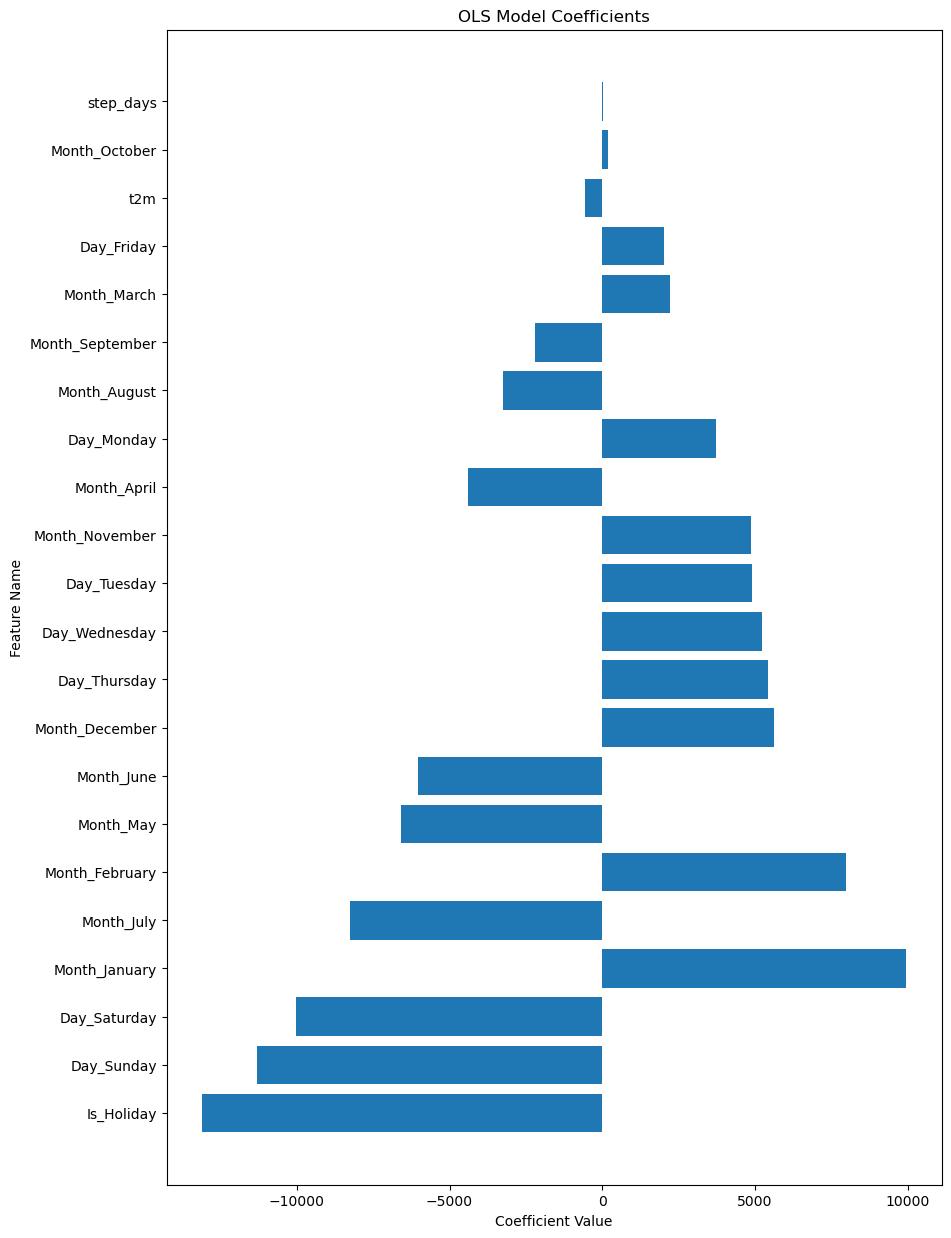

In [56]:
# Get the coefficients from the OLS model
coefficients = ols_model.coef_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to hold coefficients and feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coeff_df['abs_coeff'] = np.abs(coeff_df['Coefficient'])
coeff_df = coeff_df.sort_values(by='abs_coeff', ascending=False)

# Drop the column used for sorting
coeff_df.drop('abs_coeff', axis=1, inplace=True)

# Plot the coefficients
plt.figure(figsize=(10, 15))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('OLS Model Coefficients')
plt.show()

As we can see from the coefficients, the model identifies many of the same patterns that we observed in the [data](https://madsh0402.github.io/Forecasting-energy-consumption-in-Denmark/Data/Energy/Markdown/Energy%20Data/) section. This includes a lot of negative impact from factors such as holidays and weekends. Likewise, the model also finds a significant positive influence from the winter months. However, we still have a very low $R^2$, which could indicate a variety of issues:

1. **Non-Linearity of the Response-Variable Relationship**: The relationship between the dependent and independent variables may not be linear, making it difficult for a linear model to capture the underlying pattern effectively.

2. **Multicollinearity**: The presence of highly correlated predictors can make it difficult for the model to isolate the individual impact of each predictor, leading to poor generalization performance.

3. **Outliers**: Outliers in the data can significantly impact the sum of the squared errors, leading to a high MSE and low $R^2$

4. **Residual Errors**: The model may suffer from heteroscedasticity or non-normal distribution of error terms, which violates the assumptions of OLS.

5. **High-Dimensional Space**: With many predictors, the model may fit well to the training data but generalize poorly, a phenomenon known as overfitting.

6. **Feature Scaling**: Sometimes, the scales of your variables can affect the results, although in linear models with normally-distributed errors, this shouldn't be a big issue.

7. **Interactions and Polynomial Terms**: It's possible that the model could be improved by including interaction terms, polynomial terms, or other transformations of the predictors.